# Notebook of Figure 7 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows seasonal spectra analysis of the kinetic energy field and kinetic energy fluxes at the surface and interior.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [3]:
import nc_time_axis

In [4]:
from dask.distributed import Client
import dask
import os

client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33771 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33771/status,
Dashboard: http://127.0.0.1:33771/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39559,Workers: 8
Dashboard: http://127.0.0.1:33771/status,Total threads: 8
Started: 3 minutes ago,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:60485,Total threads: 1
Dashboard: http://127.0.0.1:37694/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54613,


In [5]:
from utils import Import_Expt_Front, date_fmt

## Load data

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [8]:
dataset_gridT_1d = EXF.import_multipe_expt('grid_T',vars_of_interest=['ke'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1},decode_cf=False)

In [9]:
dataset_gridT_1d = xr.decode_cf(dataset_gridT_1d)

In [10]:
from utils import compute_PSD, compute_PSD_dataset 

In [11]:
def compute_PSD_dataset(dataset,indx=None):    
    dataset_dict = {}
    for var in list(dataset.data_vars):
        if indx!=None:
            FFT, PSD, om_welch = compute_PSD(dataset[var].isel(indx),dx=250)
        else:
            FFT, PSD, om_welch = compute_PSD(dataset[var],dx=250)
            
        dataset_dict[var+"_FFT"] = {'dims':('n','x'),'data': FFT} 
        dataset_dict[var+"_PSD"] = {'dims':('n','x'),'data':PSD,'attrs':{'long_name':dataset[var].long_name,'units':dataset[var].units}} 
        dataset_dict[var+"_om"] = {'dims':('n','x'),'data':om_welch}
    dataset = xr.Dataset.from_dict(dataset_dict)
    return dataset

def compute_PSD_dataset_2D(dataset,var,indx=None):    
#     dataset_dict = dataset.copy()
#     dataset_dict.expand_dims(dim={"axis": len(dataset[indx])})
    dataset_dict=[]
    for ii in dataset[indx].values:
        dataset_out = compute_PSD_dataset(dataset.sel({indx:ii}))
        dataset_dict.append(dataset_out)
        concat_dataset = xr.concat(dataset_dict,dim="y")
    concat_dataset['n']=dataset.time_counter.values
    return concat_dataset.rename({"n":"time"}).transpose("time","x","y")

## Compute the KE and spectra

In [12]:
ke_surface = dataset_gridT_1d.sel(deptht=5,method="nearest").sel(time_counter='0002')

In [13]:
## Uncomment to compute the spectra at 5m.
# data = ke_surface.isel(y=slice(100,1100)).load()
# PSD_ke = compute_PSD_dataset_2D(data,'ke_006','y')
# PSD_ke.to_netcdf('./storage/spectra_5m_KE_125km.nc')

In [14]:
# Load spectra at 5m
PSD_ke= xr.open_dataset('./storage/spectra_5m_KE_125km.nc')

In [15]:
ke_150m = dataset_gridT_1d.sel(deptht=150,method="nearest").sel(time_counter='0002')

In [16]:
## Uncomment to compute the spectra at 150m.
# data_100m = ke_150m.isel(y=slice(100,1100)).load()
# PSD_ke_100m = compute_PSD_dataset_2D(data_100m,'ke_006','y')
# PSD_ke_100m.to_netcdf('./storage/spectra_150m_KE_125km.nc')

In [17]:
# Load spectra at 150m
PSD_ke_100m = xr.open_dataset('./storage/spectra_150m_KE_125km.nc')

## Load KE energy flux

In [18]:
ds = xr.open_dataset("./storage/KE_energy_flux_at_5m_between_125km_from_center_fix_dx_1D.nc")
ds_150 = xr.open_dataset("./storage/KE_energy_flux_at_150m_between_125km_from_center_fix_dx_1D.nc")

In [19]:
ds['wavenumber'] = ds.wavenumber*1000
ds_150['wavenumber'] = ds_150.wavenumber*1000

In [20]:
KEFlux_season = ds.KEflux.groupby("time_counter.season").mean().mean('y')
KEFlux_season_150 = ds_150.KEflux.groupby("time_counter.season").mean().mean('y')

KEFlux_std_season = ds.KEflux.groupby("time_counter.season").mean().std('y')
KEFlux_std_season_150 = ds_150.KEflux.groupby("time_counter.season").mean().std('y')

## Plot utils

In [21]:
import matplotlib
def add_distance_axis(ax,fontsize=12):
    ax_ = ax.twiny()

    ax_.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax_.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax_.spines['bottom'].set_position(('outward', 36))
    ax_.set_xlim(ax.get_xlim())
    ax_.set_xlabel("Wavelength [km]", fontsize= fontsize)


    labels = ax_.get_xticklabels()
    new_label=list(np.zeros(len(labels)))
    count=0
    for label in labels:
        nl = np.round(1 / label.get_position()[0], 1)
        if nl==np.inf:
            new_label[count] = "Inf"
        else:
            new_label[count] = "{0}".format(nl)
        count+=1

    ax_.set_xticklabels(new_label) 
    
    return ax_


def add_distance_axis_log(ax,fontsize=12):
    ax_ = ax.twiny()

    ax_.set_xscale('log')
    ax_.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax_.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax_.spines['bottom'].set_position(('outward', 36))
    ax_.set_xlim(ax.get_xlim())
    ax_.set_xlabel("Wavelength [km]", fontsize= fontsize)


    labels = ax_.get_xticklabels()
    new_label=list(np.zeros(len(labels)))
    count=0
    for label in labels:
        nl = np.round(1 / label.get_position()[0], 1)
        if nl==np.inf:
            new_label[count] = "Inf"
        else:
            new_label[count] = "{0}".format(nl)
        count+=1

    ax_.set_xticklabels(new_label)
    
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(1/np.arange(1,10)),numticks=12)
    ax_.xaxis.set_minor_locator(locmin)
    ax_.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    return ax_



### Load Rossby Radious

In [22]:
R1_ts = xr.open_dataset("./storage/Rossby_radius.nc")
R1_ts_STD = xr.open_dataset("./storage/Rossby_radius_STD.nc")

In [23]:
R1min = np.min(R1_ts.bn2_006).values/1000
R1max = np.max(R1_ts.bn2_006).values/1000

In [24]:
from numpy import mean, absolute
from scipy import stats

def mad(data, axis=None):
    return stats.median_abs_deviation(data,axis)
#mean(absolute(data - mean(data, axis)), axis)

## Plotting

/dev/shm/pbs.3989604.datarmor0/ipykernel_19221/689598169.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_.set_xticklabels(new_label)
/dev/shm/pbs.3989604.datarmor0/ipykernel_19221/689598169.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_.set_xticklabels(new_label)


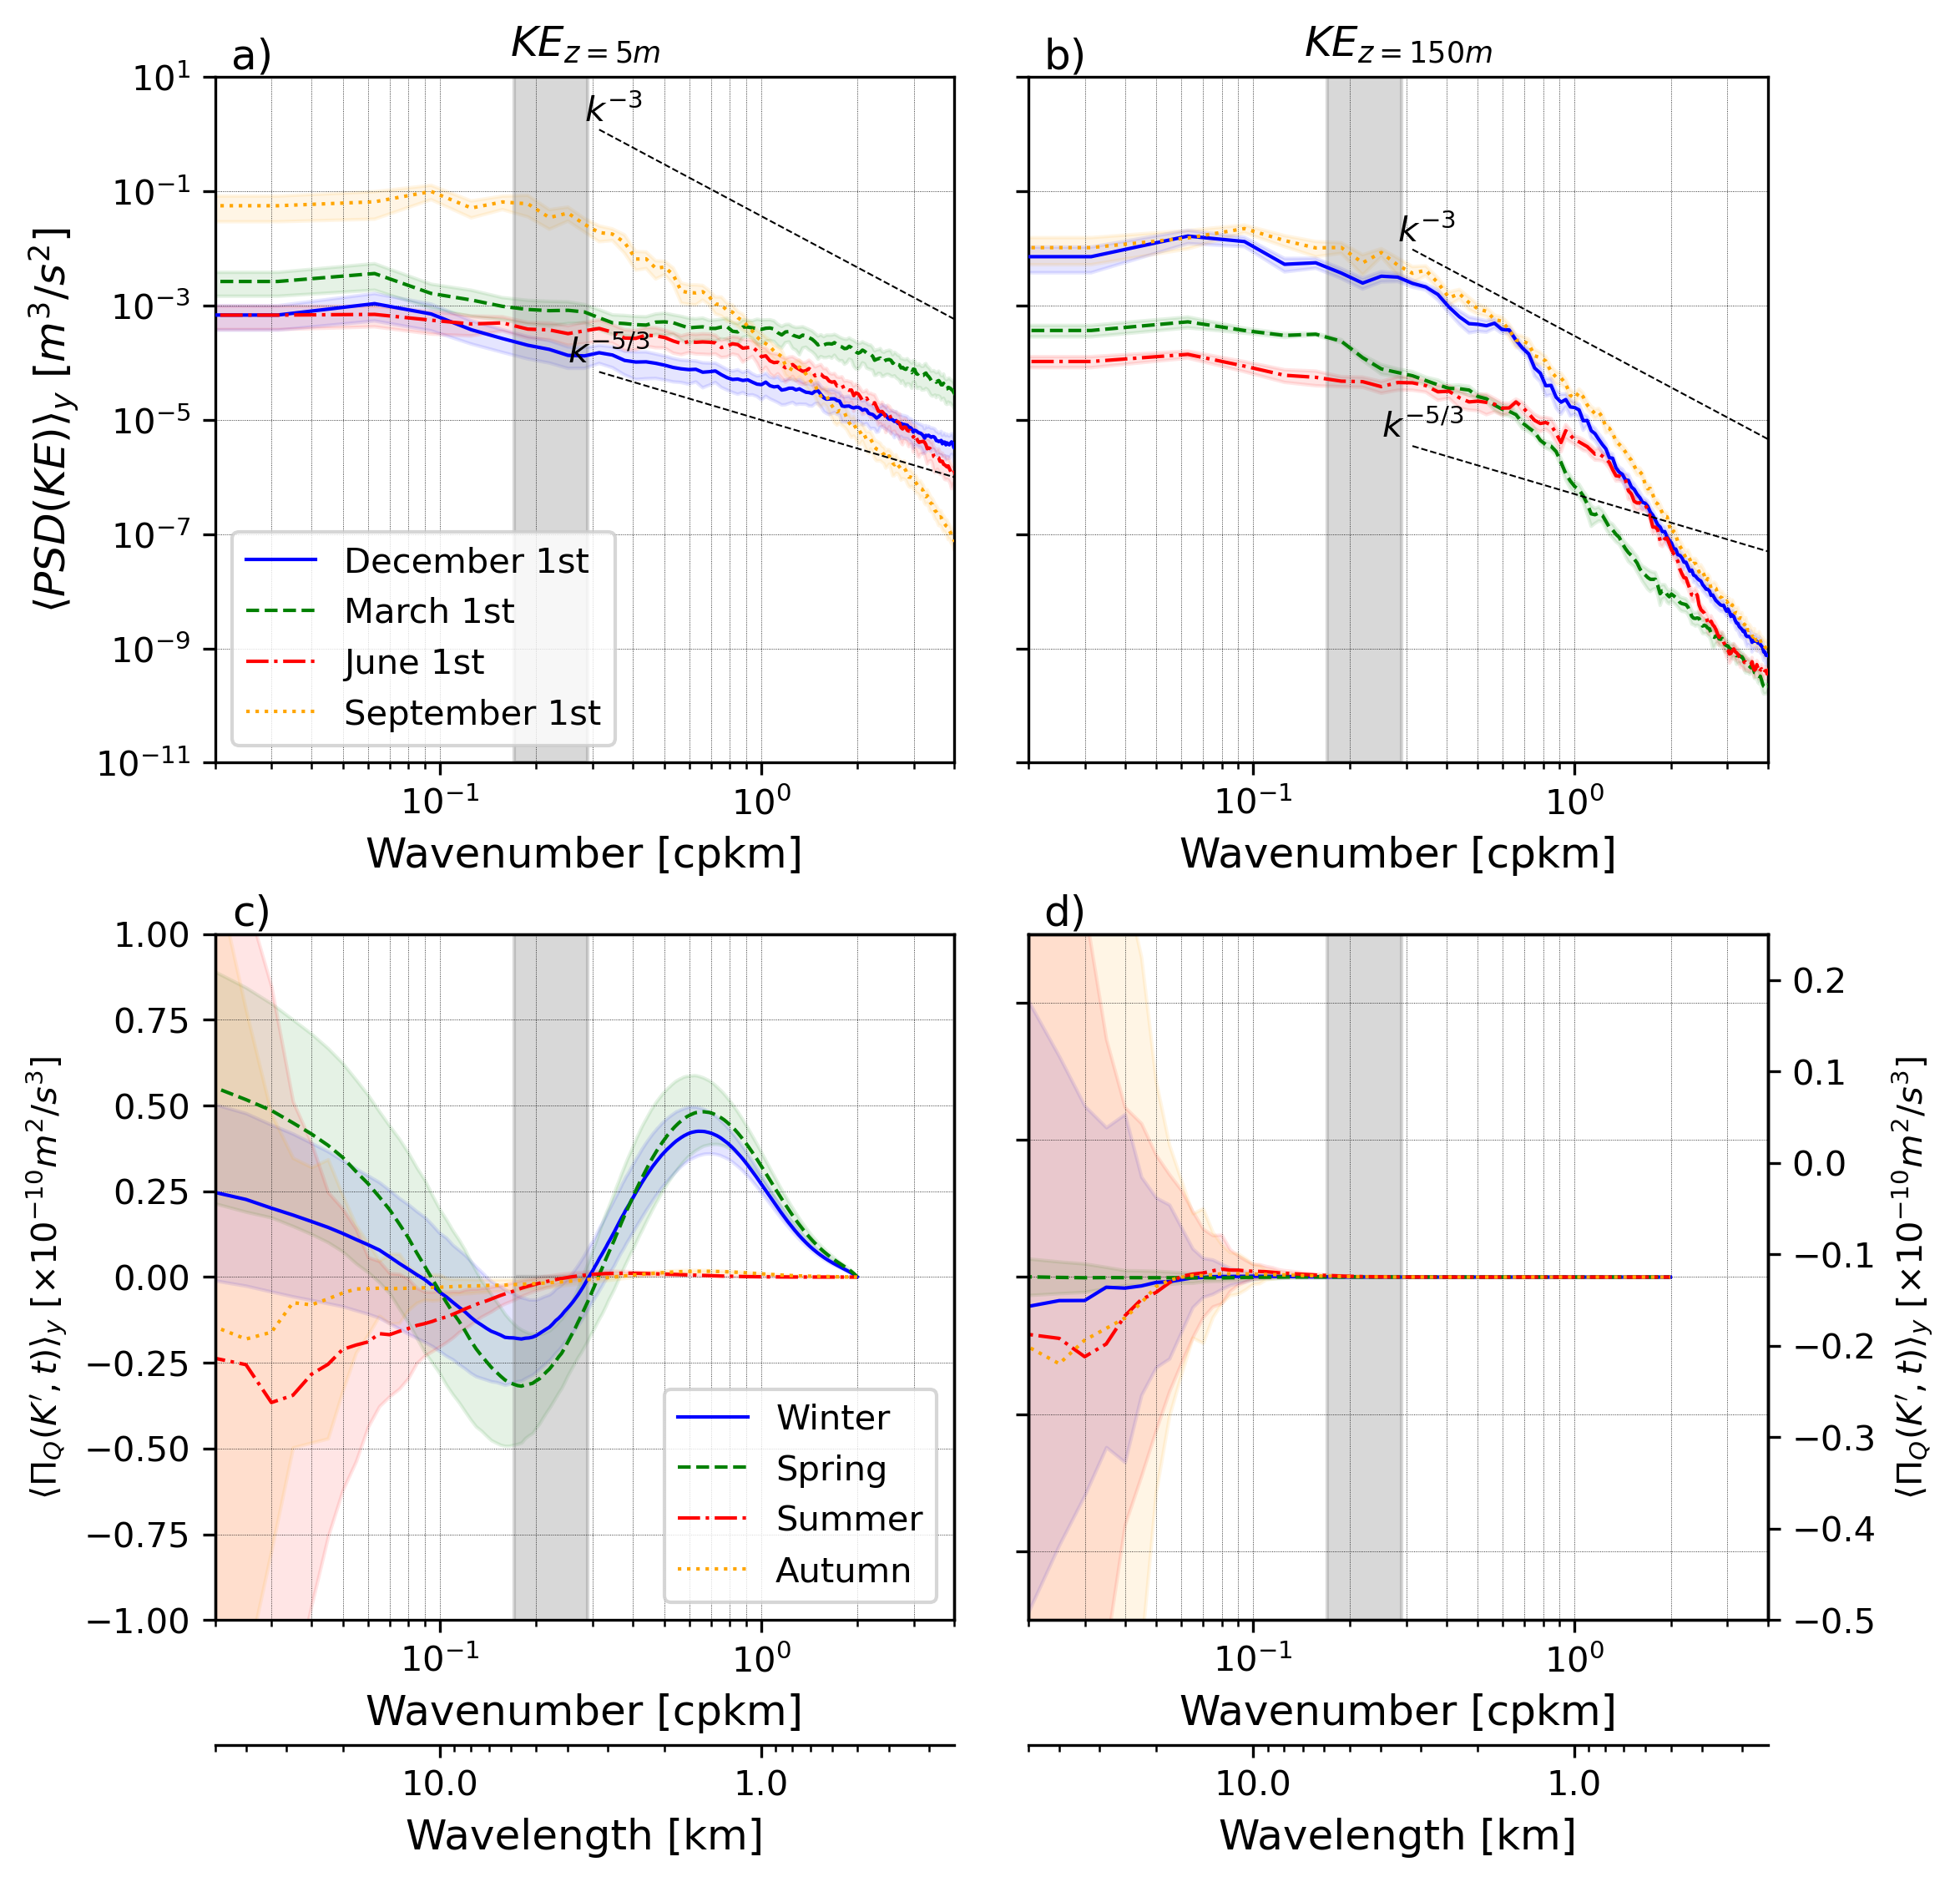

In [25]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=300)

fontsize=12

xaxis = PSD_ke["ke_006_om"].mean('y')*1000
PSD =  PSD_ke["ke_006_PSD"].mean('y')
mean_PSD = PSD.groupby("time.season").mean()

index_max = PSD_ke["ke_006_PSD"].sum('x').argmax("y")
index_min = PSD_ke["ke_006_PSD"].sum('x').argmin("y")

index_min = index_min.where(index_min>50,50)
index_min = index_min.where(index_min<950,950)
index_max = index_max.where(index_max>50,50)
index_max = index_max.where(index_max<950,950)

# min_PSD = mean_PSD - PSD_ke["ke_006_PSD"].groupby("time.season").mean().std("y")
# max_PSD = mean_PSD + PSD_ke["ke_006_PSD"].groupby("time.season").mean().std("y")

min_PSD_DJF = PSD_ke["ke_006_PSD"].sel(time="0002-12-01").squeeze().mean('y') - mad(PSD_ke["ke_006_PSD"].sel(time="0002-12-01").squeeze(),axis=1)
max_PSD_DJF = PSD_ke["ke_006_PSD"].sel(time="0002-12-01").squeeze().mean('y') + mad(PSD_ke["ke_006_PSD"].sel(time="0002-12-01").squeeze(),axis=1)
min_PSD_MAM = PSD_ke["ke_006_PSD"].sel(time="0002-03-01").squeeze().mean('y') - mad(PSD_ke["ke_006_PSD"].sel(time="0002-03-01").squeeze(),axis=1)
max_PSD_MAM = PSD_ke["ke_006_PSD"].sel(time="0002-03-01").squeeze().mean('y') + mad(PSD_ke["ke_006_PSD"].sel(time="0002-03-01").squeeze(),axis=1)
min_PSD_JJA = PSD_ke["ke_006_PSD"].sel(time="0002-06-01").squeeze().mean('y') - mad(PSD_ke["ke_006_PSD"].sel(time="0002-06-01").squeeze(),axis=1)
max_PSD_JJA = PSD_ke["ke_006_PSD"].sel(time="0002-06-01").squeeze().mean('y') + mad(PSD_ke["ke_006_PSD"].sel(time="0002-06-01").squeeze(),axis=1)
min_PSD_SON = PSD_ke["ke_006_PSD"].sel(time="0002-09-01").squeeze().mean('y') - mad(PSD_ke["ke_006_PSD"].sel(time="0002-09-01").squeeze(),axis=1)
max_PSD_SON = PSD_ke["ke_006_PSD"].sel(time="0002-09-01").squeeze().mean('y') + mad(PSD_ke["ke_006_PSD"].sel(time="0002-09-01").squeeze(),axis=1)

# std_PSD = PSD.groupby("time.season").std()

ax0=ax[0,0]

ax0.plot(xaxis[0,:],PSD.sel(time="0002-12-01").squeeze(),linewidth=1,color="blue",zorder=3, label="December 1st")
ax0.fill_between(xaxis[0,:], min_PSD_DJF, max_PSD_DJF, color="blue", alpha=0.1)

ax0.plot(xaxis[0,:],PSD.sel(time="0002-03-01").squeeze(),linewidth=1,color="green",zorder=3, label="March 1st",linestyle="--")
ax0.fill_between(xaxis[0,:], min_PSD_MAM, max_PSD_MAM, color="green", alpha=0.1)

ax0.plot(xaxis[0,:],PSD.sel(time="0002-06-01").squeeze(),linewidth=1,color="red",zorder=3, label="June 1st",linestyle="-.")
ax0.fill_between(xaxis[0,:], min_PSD_JJA, max_PSD_JJA, color="red", alpha=0.1)

ax0.plot(xaxis[0,:],PSD.sel(time="0002-09-01").squeeze(),linewidth=1,color="orange",zorder=3, label="September 1st",linestyle=":")
ax0.fill_between(xaxis[0,:], min_PSD_SON, max_PSD_SON, color="orange", alpha=0.1)

ax0.set_yscale('log')
ax0.set_xscale('log')

ax0.plot(xaxis[0,10:200],(xaxis[0,10:200]*1000)**(-5/3),linestyle='--',linewidth=0.5,color='k',zorder=5)
ax0.text(xaxis[0,8],(xaxis[0,8]*1000)**(-5/3), r"$k^{-5/3}$")

ax0.plot(xaxis[0,10:200],(xaxis[0,10:200]*3)**-3,linestyle='--',linewidth=0.5,color='k',zorder=5)
ax0.text(xaxis[0,9],(xaxis[0,9]*3)**-3, r"$k^{-3}$")

ax0.set_xlabel('Wavenumber [cpkm]', fontsize= fontsize )
ax0.set_ylabel(r'$\left<PSD(KE)\right>_y$ [$m^3/s^2]$', fontsize= fontsize )
ax0.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax0.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
# ax0.axvline(x=1/L1,color='k', ls = ':')
ax0.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[1e-11,1e-11,1e1,1e1],color='gray',alpha=0.3)
ax0.set_title(r'$KE_{z=5m}$')

ax0.legend()

ax0.set_ylim((1e-11,1e1))
ax0.set_xlim((1/50,1/0.25))

# add_distance_axis_log(ax0)

##################################################################################################################################
##################################################################################################################################

xaxis = PSD_ke_100m["ke_006_om"].mean('y')*1000
PSD =  PSD_ke_100m["ke_006_PSD"].mean('y')
mean_PSD = PSD.groupby("time.season").mean()

index_max = PSD_ke_100m["ke_006_PSD"].sum('x').argmax("y")
index_min = PSD_ke_100m["ke_006_PSD"].sum('x').argmin("y")

index_min = index_min.where(index_min>50,50)
index_min = index_min.where(index_min<950,950)
index_max = index_max.where(index_max>50,50)
index_max = index_max.where(index_max<950,950)


min_PSD_DJF = PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze().mean('y') - mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze(),axis=1)
max_PSD_DJF = PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze().mean('y') + mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze(),axis=1)
min_PSD_MAM = PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze().mean('y') - mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze(),axis=1)
max_PSD_MAM = PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze().mean('y') + mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze(),axis=1)
min_PSD_JJA = PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze().mean('y') - mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze(),axis=1)
max_PSD_JJA = PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze().mean('y') + mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze(),axis=1)
min_PSD_SON = PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze().mean('y') - mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze(),axis=1)
max_PSD_SON = PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze().mean('y') + mad(PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze(),axis=1)


# min_PSD_DJF =  PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze().std("y")#.isel(y=slice(index_min.sel(time="0002-12-01").squeeze().values-30,index_min.sel(time="0002-12-01").squeeze().values+30)).mean('y')
# max_PSD_DJF = PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze().mean('y') + PSD_ke_100m["ke_006_PSD"].sel(time="0002-12-01").squeeze().std("y")#.isel(y=slice(index_max.sel(time="0002-12-01").squeeze().values-30,index_max.sel(time="0002-12-01").squeeze().values+30)).mean('y')
# min_PSD_MAM =  PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze().std("y")#.isel(y=slice(index_min.sel(time="0002-03-01").squeeze().values-30,index_min.sel(time="0002-03-01").squeeze().values+30)).mean('y')
# max_PSD_MAM = PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze().mean('y') + PSD_ke_100m["ke_006_PSD"].sel(time="0002-03-01").squeeze().std("y")#.isel(y=slice(index_max.sel(time="0002-03-01").squeeze().values-30,index_max.sel(time="0002-03-01").squeeze().values+30)).mean('y')
# min_PSD_JJA =  PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze().std("y")#.isel(y=slice(index_min.sel(time="0002-06-01").squeeze().values-30,index_min.sel(time="0002-06-01").squeeze().values+30)).mean('y')
# max_PSD_JJA = PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze().mean('y') + PSD_ke_100m["ke_006_PSD"].sel(time="0002-06-01").squeeze().std("y")#.isel(y=slice(index_max.sel(time="0002-06-01").squeeze().values-30,index_max.sel(time="0002-06-01").squeeze().values+30)).mean('y')
# min_PSD_SON =  PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze().std("y")#.isel(y=slice(index_min.sel(time="0002-09-01").squeeze().values-30,index_min.sel(time="0002-09-01").squeeze().values+30)).mean('y')
# max_PSD_SON = PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze().mean('y') + PSD_ke_100m["ke_006_PSD"].sel(time="0002-09-01").squeeze().std("y")#.isel(y=slice(index_max.sel(time="0002-09-01").squeeze().values-30,index_max.sel(time="0002-09-01").squeeze().values+30)).mean('y')

ax1=ax[0,1]

ax1.plot(xaxis[0,:],PSD.sel(time="0002-12-01").squeeze(),linewidth=1,color="blue",zorder=3, label="December 1st")
ax1.fill_between(xaxis[0,:], min_PSD_DJF, max_PSD_DJF, color="blue", alpha=0.1)

ax1.plot(xaxis[0,:],PSD.sel(time="0002-03-01").squeeze(),linewidth=1,color="green",zorder=3, label="March 1st",linestyle="--")
ax1.fill_between(xaxis[0,:], min_PSD_MAM, max_PSD_MAM, color="green", alpha=0.1)

ax1.plot(xaxis[0,:],PSD.sel(time="0002-06-01").squeeze(),linewidth=1,color="red",zorder=3, label="June 1st",linestyle="-.")
ax1.fill_between(xaxis[0,:], min_PSD_JJA, max_PSD_JJA, color="red", alpha=0.1)

ax1.plot(xaxis[0,:],PSD.sel(time="0002-09-01").squeeze(),linewidth=1,color="orange",zorder=3, label="September 1st",linestyle=":")
ax1.fill_between(xaxis[0,:], min_PSD_SON, max_PSD_SON, color="orange", alpha=0.1)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.plot(xaxis[0,10:200],(xaxis[0,10:200]*6000)**(-5/3),linestyle='--',linewidth=0.5,color='k',zorder=5)
ax1.text(xaxis[0,8],(xaxis[0,8]*6000)**(-5/3), r"$k^{-5/3}$")

ax1.plot(xaxis[0,10:200],(xaxis[0,10:200]*15)**-3,linestyle='--',linewidth=0.5,color='k',zorder=5)
ax1.text(xaxis[0,9],(xaxis[0,9]*15)**-3, r"$k^{-3}$")

ax1.set_xlabel('Wavenumber [cpkm]', fontsize= fontsize)

# ax1.tick_params(labelsize=12)
ax1.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
# ax1.axvline(x=1/L2,color='k', ls = ':', label=r"$2\pi R_d$")
# ax1.axvline(x=1/L1,color='k', ls = ':')
ax1.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[1e-11,1e-11,1e1,1e1],color='gray',alpha=0.3)

ax1.set_title(r'$KE_{z=150m}$')

ax1.yaxis.set_ticklabels([])

ax1.set_ylim((1e-11,1e1))
ax1.set_xlim((1/50,1/0.25))


# add_distance_axis_log(ax1)

##################################################################################################################################
##################################################################################################################################

ax2=ax[1,0]

(KEFlux_season*1e10).sel(season="DJF").plot(ax=ax2,label="Winter",color="blue",linewidth=1)
(KEFlux_season*1e10).sel(season="MAM").plot(ax=ax2,label="Spring",color="green",linewidth=1,linestyle="--")
(KEFlux_season*1e10).sel(season="JJA").plot(ax=ax2,label="Summer",color="red",linewidth=1,linestyle="-.")
(KEFlux_season*1e10).sel(season="SON").plot(ax=ax2,label="Autumn",color="orange",linewidth=1,linestyle=":")


std_min = ((KEFlux_season - KEFlux_std_season) *1e10)
std_max = ((KEFlux_season + KEFlux_std_season) *1e10)

ax2.fill_between(std_min.wavenumber, std_min.sel(season="DJF") , std_max.sel(season="DJF"), color="blue", alpha=0.1)
ax2.fill_between(std_min.wavenumber, std_min.sel(season="MAM") , std_max.sel(season="MAM"), color="green", alpha=0.1)
ax2.fill_between(std_min.wavenumber, std_min.sel(season="JJA") , std_max.sel(season="JJA"), color="red", alpha=0.1)
ax2.fill_between(std_min.wavenumber, std_min.sel(season="SON") , std_max.sel(season="SON"), color="orange", alpha=0.1)

#KEFlux_std_season
#KEFlux_std_season_150

ax2.set_ylabel(r"$\left<\Pi_Q (K', t)\right>_y$ [$\times 10^{-10} m^2/s^3$]")
ax2.set_xlabel("Wavenumber [cpkm]", fontsize= fontsize)

ax2.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

# ax2.plot([Rd,Rd],[-7.5,2.5],linestyle=':',color='k')
ax2.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[-7.5,-7.5,2.5,2.5],color='gray',alpha=0.3)

# ax2.plot([Rd_2,Rd_2],[-7.5,2],linestyle=':',color='k')

# ax2.set_xlim(0,2)
ax2.set_xscale('log')
ax2.set_xlim((1/50,1/0.25))


ax2.set_ylim(-1,1)

ax2.legend(loc=4)

##################################################################################################################################

add_distance_axis_log(ax2)

ax2.set_title('')

##################################################################################################################################
##################################################################################################################################

ax3=ax[1,1]

(KEFlux_season_150*1e10).sel(season="DJF").plot(ax=ax3,color="blue",linewidth=1)
(KEFlux_season_150*1e10).sel(season="MAM").plot(ax=ax3,color="green",linewidth=1,linestyle="--")
(KEFlux_season_150*1e10).sel(season="JJA").plot(ax=ax3,color="red",linewidth=1,linestyle="-.")
(KEFlux_season_150*1e10).sel(season="SON").plot(ax=ax3,color="orange",linewidth=1,linestyle=":")


std_min = ((KEFlux_season_150 - KEFlux_std_season_150) *1e10)
std_max = ((KEFlux_season_150 + KEFlux_std_season_150) *1e10)

ax3.fill_between(std_min.wavenumber, std_min.sel(season="DJF") , std_max.sel(season="DJF"), color="blue", alpha=0.1)
ax3.fill_between(std_min.wavenumber, std_min.sel(season="MAM") , std_max.sel(season="MAM"), color="green", alpha=0.1)
ax3.fill_between(std_min.wavenumber, std_min.sel(season="JJA") , std_max.sel(season="JJA"), color="red", alpha=0.1)
ax3.fill_between(std_min.wavenumber, std_min.sel(season="SON") , std_max.sel(season="SON"), color="orange", alpha=0.1)


# ax3.set_ylabel("Spectral Kinetic Energy flux ($m^2/s^3$)")
ax3.set_xlabel("Wavenumber [cpkm]", fontsize= fontsize)

ax3.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax3.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

# ax3.plot([Rd,Rd],[-7.5,2.5],linestyle=':',color='k')
# ax3.plot([Rd_2,Rd_2],[-7.5,2],linestyle=':',color='k')
ax3.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[-7.5,-7.5,2.5,2.5],color='gray',alpha=0.3)

ax3.set_xscale('log')
ax3.set_xlim((1/50,1/0.25))
# ax3.set_xlim(0,2)

ax3.set_ylim(-0.25,0.25)

ax3_x = ax3.twinx()
ax3_x.set_ylim(-0.5,0.25)
ax3_x.set_ylabel(r"$\left<\Pi_Q (K', t)\right>_y$ [$\times 10^{-10} m^2/s^3$]")


##################################################################################################################################

add_distance_axis_log(ax3)

ax3.yaxis.set_ticklabels([])

ax3.set_ylabel('')
ax3.set_title('')

##################################################################################################################################

plt.subplots_adjust(wspace=0.1, hspace=0.25)

ax0.text(0.05, 1.03, 'a)', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes,fontsize=12)
ax1.text(0.05, 1.03, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)
ax2.text(0.05, 1.03, 'c)', horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes,fontsize=12)
ax3.text(0.05, 1.03, 'd)', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes,fontsize=12)

plt.savefig('./figures/Fig_2_spectra_and_flux_first_snapshots.pdf',dpi=300,bbox_inches='tight')


**Figure 7.** KE spectra snapshots a) at $5\ m$ depth and b) at $150\ m$ depth for the first day of each season (1st December, 1st March, 1st June, and 1st of September). KE flux averaged for each season at c) $5\ m$ and d) $150\ m$ depth. The dashed lines correspond to the $-3$ and $-5/3$ slopes typical of KE spectra. The grey vertical shaded area correspond to the Rossby radius ($R_D$) range within the second year of the simulation (see Fig. 6a). In panels a) and b) the shaded areas correspond to the median absolute deviation in the meridional direction of the KE spectra, and in panels c) and d) the shaded areas correspond to the standard deviation in the meridional direction for the seasonally averaged KE ﬂux.